In [ ]:
!pip install -qq yellowbrick

In [ ]:
# some builtin imports
import re
import warnings
from collections import Counter
import time
from datetime import datetime
warnings.filterwarnings('ignore')

# Some usual imports here
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl


# sklearn models
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from sklearn import metrics, model_selection

# visualizations
import shap
from yellowbrick.regressor import residuals_plot, prediction_error

In [ ]:
## Customize Matplotlib Parameters
%matplotlib inline
mpl.rcParams['figure.dpi']= 120
mpl.rcParams['figure.edgecolor']= 'black'
mpl.rcParams['axes.linewidth']= .5
# Customize Seaborn Parameters
sns.set()
rc = {
      'font.family': ['serif'],
      'font.serif':'Times New Roman',
      'grid.color': 'gainsboro',
      'grid.linestyle': '-',
}
sns.set_style(rc=rc)
sns.set_context("notebook", font_scale=0.8)

In [ ]:
from google.colab import files
uploaded = files.upload()


In [ ]:
df = pd.read_csv('house_rental_fin.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17890 entries, 0 to 17889
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   category_Flats                 17890 non-null  float64
 1   category_Detached              17890 non-null  float64
 2   category_Townhouse             17890 non-null  float64
 3   category_Duplex                17890 non-null  float64
 4   category_Mansion               17890 non-null  float64
 5   category_Semi-Detached         17890 non-null  float64
 6   bedrooms                       17890 non-null  float64
 7   bathrooms                      17890 non-null  float64
 8   floor_area                     17890 non-null  float64
 9   condition_Used                 17890 non-null  float64
 10  condition_New                  17890 non-null  float64
 11  condition_Renovated            17890 non-null  float64
 12  amenities_24-hour electricity  17890 non-null 

In [ ]:
def compute_metrics(model, x, y, cv=5):
    preds = model.predict(x)
    score = model.score(x, y)

    ms = {
        "R2": round(score, 3),
        "mse": round(metrics.mean_squared_error(y, preds), 3),
        "rmse": round(np.sqrt(metrics.mean_squared_error(y, preds)), 3),
        "mae": round(metrics.mean_absolute_error(y, preds), 3),
        "adjusted_r2": round(1 - (1 - score) * (len(y) - 1) / (len(y) - x.shape[1] - 1), 3),
    }
    if cv is not None:
        scores_cvs = model_selection.cross_val_score(model, x, y, scoring='r2', cv=cv)
        ms['cv_score'] = round(scores_cvs.mean()*100, 2)

    return pd.DataFrame([ms])

In [ ]:
# train-test split for model evaluation
X = df.drop(['price', 'log1p_price'], axis=1).values
y = df['log1p_price'].values

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, train_size=0.8, shuffle=True, random_state=42
)

In [ ]:
X_train.shape, X_test.shape

((14312, 37), (3578, 37))

In [ ]:
model = MLPRegressor(random_state=17, max_iter=500)
model = model.fit(X_train, y_train)

In [ ]:
train_metrics = compute_metrics(model, X_train, y_train)
train_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.885,0.149,0.386,0.293,0.884,81.34


In [ ]:
val_metrics = compute_metrics(model, X_test, y_test)
val_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.826,0.229,0.479,0.35,0.824,75.97


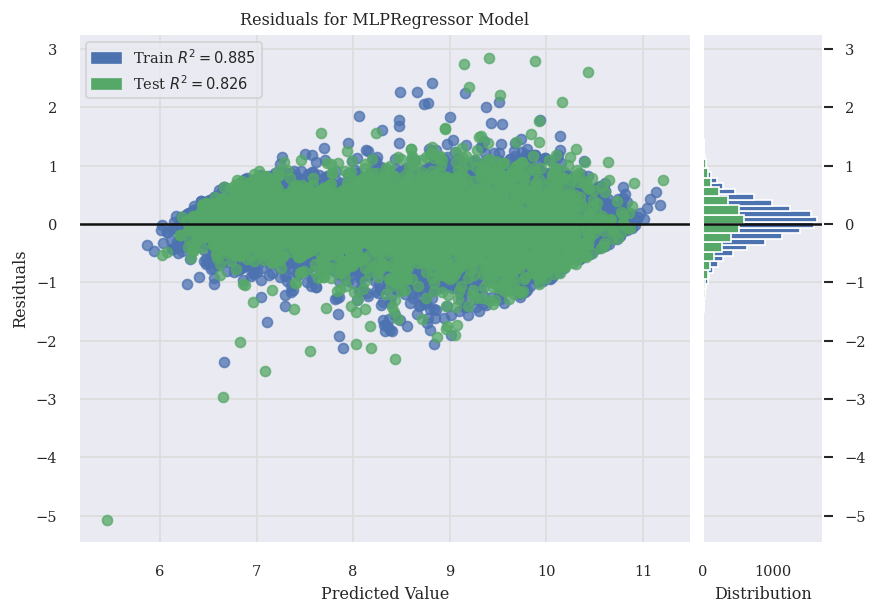

In [ ]:

visualizer = residuals_plot(
    model, X_train, y_train, X_test, y_test,
)

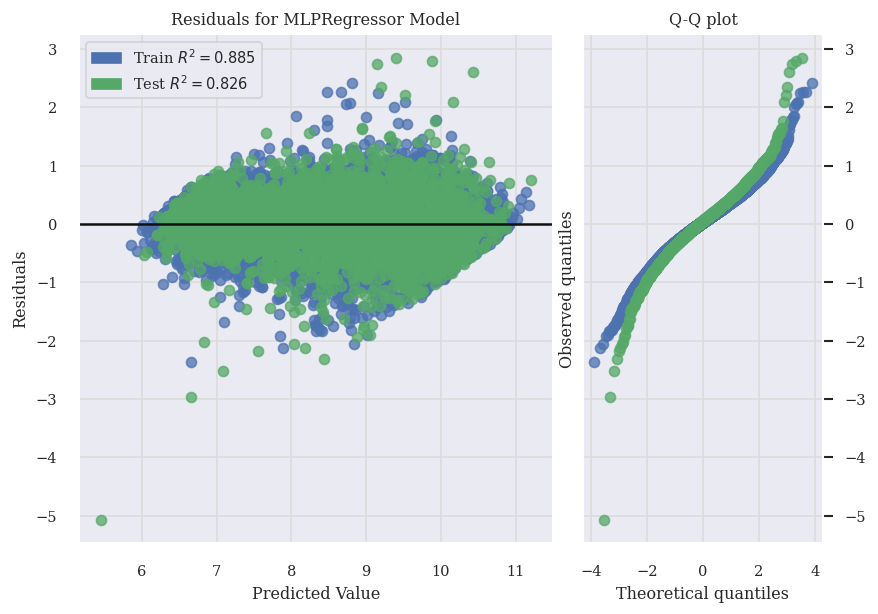

In [ ]:
visualizer = residuals_plot(
    model, X_train, y_train, X_test, y_test, hist=False, qqplot=True
)

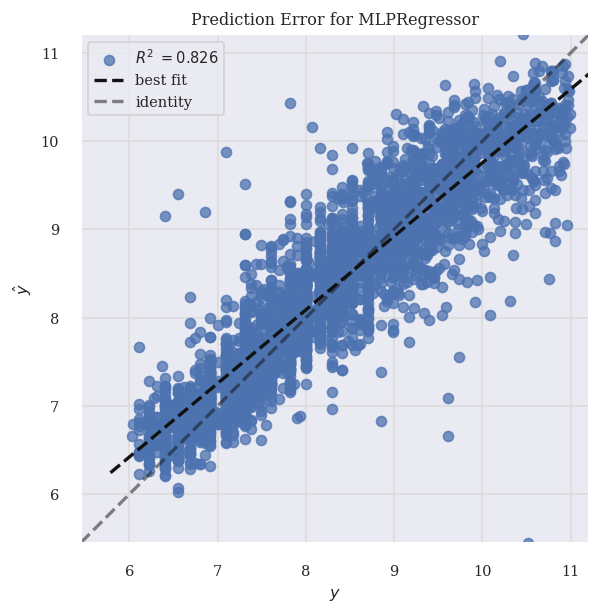

In [ ]:
visualizer = prediction_error(model, X_train, y_train, X_test, y_test)

In [ ]:
preds = model.predict(X_test)

In [ ]:
# Reverse the log transformation
actual_preds = np.expm1(preds)
actual_y_test = np.expm1(y_test)

# Compute metrics on the original scale
def compute_metrics_original_scale(y_true, y_pred):
    return pd.DataFrame([{
        "R2": round(metrics.r2_score(y_true, y_pred), 3),
        "mse": round(metrics.mean_squared_error(y_true, y_pred), 3),
        "rmse": round(np.sqrt(metrics.mean_squared_error(y_true, y_pred)), 3),
        "mae": round(metrics.mean_absolute_error(y_true, y_pred), 3),
    }])

val_metrics_original_scale = compute_metrics_original_scale(actual_y_test, actual_preds)
val_metrics_original_scale

,R2,mse,rmse,mae
0,0.658,3.986334e+07,6313.742,3103.425


In [ ]:
pred_df = pd.DataFrame({"actual": actual_y_test, "pred": actual_preds})
pred_df.head(10)

,actual,pred
0,2000.0,2786.595124
1,2500.0,3942.535225
2,1500.0,1230.786894
3,1000.0,1068.209343
4,4000.0,7955.131159
5,3500.0,4881.062848
6,5000.0,3897.846425
7,3000.0,3082.105400
8,8000.0,9266.158194
9,1200.0,818.749698


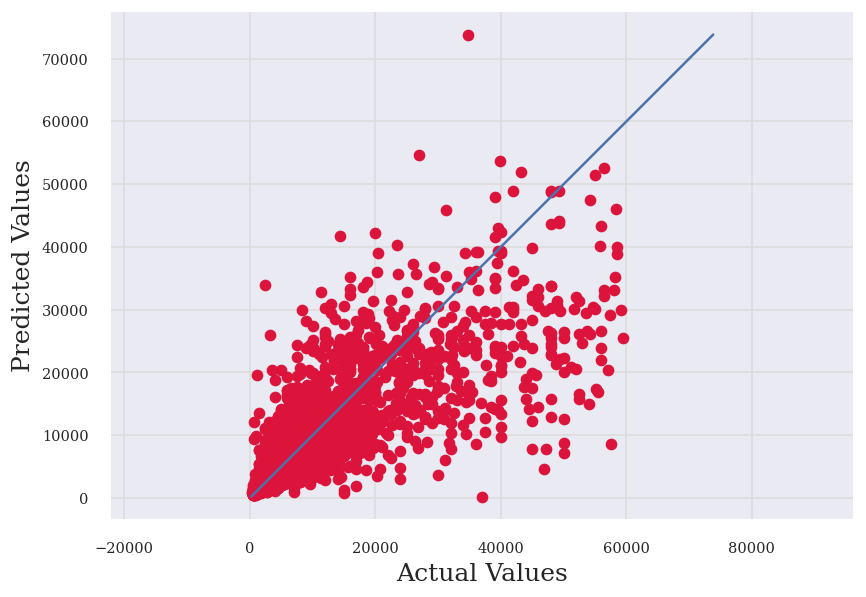

In [ ]:
plt.scatter(pred_df.actual, pred_df.pred, c='crimson')
p1 = max(max(pred_df.actual), max(pred_df.pred))
p2 = min(min(pred_df.actual), min(pred_df.pred))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Predicted Values', fontsize=15)
plt.axis('equal')
plt.show()

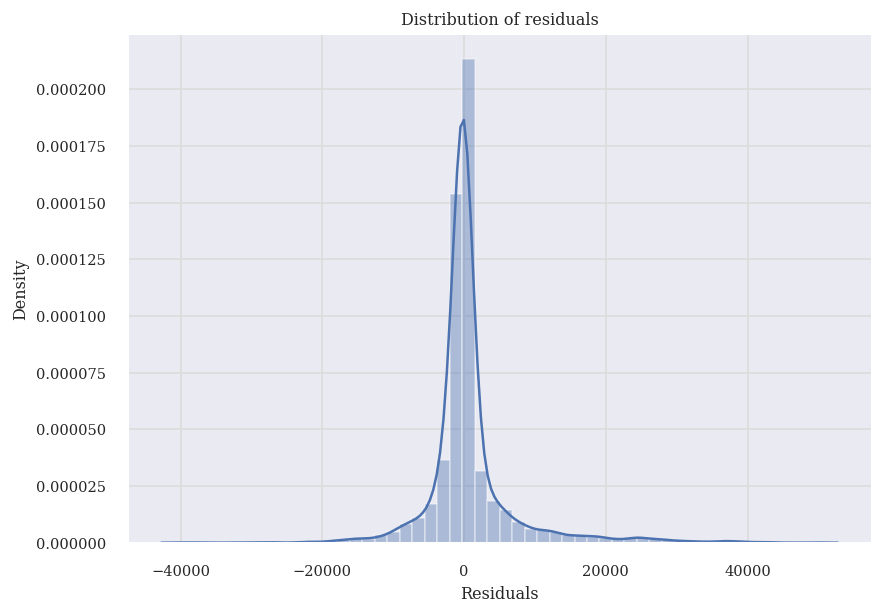

In [ ]:
sns.distplot((pred_df.actual-pred_df.pred))
plt.title('Distribution of residuals')
plt.xlabel("Residuals")
plt.show()